Arpitha Gurumurthy </br>
Team: Amalgam
# **Factor: Style Based approaches for fake news detection**
There are mainly two typical categories of style-based
methods: 
* Deception-oriented
  * Deception-oriented stylometric methods capture the
deceptive statements or claims from news content.
  * Rhetorical structure theory can be utilized to capture
the differences between deceptive and truthful sentences
* Rhetoric - language designed to have a persuasive or impressive effect on its audience, but often regarded as lacking in sincerity or meaningful content
*  Objectivity-oriented
  * Objectivity-oriented approaches capture style signals
that can indicate a decreased objectivity of news content
and thus the potential to mislead consumers, such
as hyperpartisan styles and yellow-journalism.



### Micro factors for Style based based on the above stated points:
* Hyperpartisan: Extremely one sided
* Yellow Journalism: relying on eye-catching headlines
* Rhetorical structure theory (for future work)

### Articles for reference:
* https://arxiv.org/pdf/1708.01967.pdf
* https://arxiv.org/pdf/1702.05638.pdf
* https://www.aclweb.org/anthology/S19-2187.pdf

Hyperpartisan styles represent extreme behavior in favor of a
particular political party, which often correlates with
a strong motivation to create fake news.

**Data**: SemEval Hyperpartisan News Detection task dataset.

**Dates**: Timestamp('1902-02-01') - Timestamp('2018-08-28')



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My Drive/hyperpartisan/

/content/gdrive/My Drive/hyperpartisan


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from nltk.corpus import stopwords

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df_hyperpartisan = pd.read_csv('Hyperpartisan_data.csv')
df_hyperpartisan = df_hyperpartisan.drop(columns='Unnamed: 0', axis=1)

In [ ]:
df_hyperpartisan.head()

,hyperpartisan,published_at,text,title,url
0,True,2017-09-10,Money ( Image by 401(K) 2013) Permission Detai...,Kucinich: Reclaiming the money power,https://www.opednews.com/articles/Kucinich-Rec...
1,True,2017-10-12,Donald Trump ran on many braggadocios and larg...,Trump Just Woke Up & Viciously Attacked Puerto...,http://bipartisanreport.com/2017/10/12/trump-j...
2,True,2017-10-11,In response to Joyce Newman&#8217;s recent let...,"Liberals wailing about gun control, but what a...",https://www.reviewjournal.com/opinion/letters/...
3,True,2017-09-24,After Colin Kaepernick rightly chose to kneel ...,Laremy Tunsil joins NFL players in kneeling du...,https://www.redcuprebellion.com/2017/9/24/1635...
4,False,2017-10-12,"Almost a half-century ago, in 1968, the United...",It's 1968 All Over Again,https://www.realclearpolitics.com/articles/201...


In [ ]:
df_hyperpartisan['published_at'] = pd.to_datetime(df_hyperpartisan['published_at'])

In [ ]:
df_hyperpartisan['published_at'].min()

Timestamp('1902-02-01 00:00:00')

In [ ]:
df_hyperpartisan['published_at'].max()

Timestamp('2018-08-28 00:00:00')

In [ ]:
df_hyperpartisan['year'] = df_hyperpartisan['published_at'].dt.year

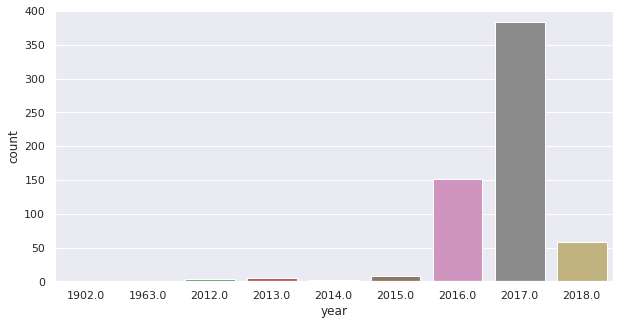

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="darkgrid")
plt.figure(figsize=(10,5))
ax = sns.countplot(x="year", data=df_hyperpartisan)

## **Steps**
1. Convert to text and label to array

In [ ]:
text_array = df_hyperpartisan['text'].to_numpy()

In [ ]:
label_array = df_hyperpartisan['hyperpartisan'].to_numpy()

2. GloVe is an unsupervised learning algorithm for obtaining vector representations for words

In [ ]:
def read_glove(path, dim):
    '''
    read the glove vectors from path with dimension dim
    '''
    df = pd.read_csv(path + 'glove.6B.' + str(dim) + 'd.txt', sep=" ", quoting=3, header=None, index_col=0)
    glove = {key: val.values for key, val in df.T.items()}
    return glove

In [ ]:
def fixedTestSplit(labels):
    '''
    split into training and held-out test set with balanced class
    '''
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state = 1)
    split_idx = list(sss.split(np.zeros(len(labels)), labels))[0]
    return split_idx[0], split_idx[1]

In [ ]:
# set path for data
pretrained_wv_path = "Glove/"

# read in data and glove vectors
glove = read_glove(pretrained_wv_path, 50)

In [ ]:
# split the samples with the same seed to compare results with other methods
id1, id2 = fixedTestSplit(label_array)

In [ ]:
def gloveVectorize(glove, text):
    '''
    Find the pretrained glove vectors of the first 1000 words in the articles.
    The final vector is the average of the vectors
    '''
    dim = len(glove["the"])
    X = np.zeros( (len(text), dim) )
    for text_id, t in enumerate(text):
        tmp = np.zeros((1, dim))
        
        # tokenize and remove stopwords
        words = customTokenize(t, rm_stopwords=True)
        words = [w for w in words if w in glove.keys()]
        for word in words:
            tmp[:] += glove[word]
        X[text_id, :] = tmp/len(words)
    return X

In [ ]:
def customTokenize(text, rm_stopwords=False):
    '''
    lower, strip numbers and punctuation, remove stop words
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    words = [word for word in tokens if word.isalpha()]
    if rm_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [w for w in words if not w in stop_words]
    return words

In [ ]:
glove_texts = gloveVectorize(glove, text_array)
train_x = glove_texts[id1]
test_x = glove_texts[id2]

## **Modeling**

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score


C = [0.5, 0.6, 0.7, 0.9,1,1.1, 1.2, 5,10]
for c in C:
    kernel_svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(C=c, gamma="auto", max_iter = 1000))
    ])
    print("[KernelSVM] C=%f | acc=%f" %(c,np.mean(cross_val_score(kernel_svm, train_x, label_array[id1], cv=10))))

[KernelSVM] C=0.500000 | acc=0.782955
[KernelSVM] C=0.600000 | acc=0.789205
[KernelSVM] C=0.700000 | acc=0.782955
[KernelSVM] C=0.900000 | acc=0.776705
[KernelSVM] C=1.000000 | acc=0.773580
[KernelSVM] C=1.100000 | acc=0.776705
[KernelSVM] C=1.200000 | acc=0.773580
[KernelSVM] C=5.000000 | acc=0.745549
[KernelSVM] C=10.000000 | acc=0.754924


In [ ]:
from sklearn.linear_model import LogisticRegression

C = [0.05, 0.1, 0.5, 0.8, 0.9, 1, 2, 3, 5]
for c in C:
    lr = LogisticRegression(solver = 'lbfgs', C = c, max_iter=1000)
    print("[LogisticR] C=%f | acc=%f" %(c,np.mean(cross_val_score(lr, train_x, label_array[id1], cv=10))))

[LogisticR] C=0.050000 | acc=0.636648
[LogisticR] C=0.100000 | acc=0.686458
[LogisticR] C=0.500000 | acc=0.746023
[LogisticR] C=0.800000 | acc=0.752273
[LogisticR] C=0.900000 | acc=0.752273
[LogisticR] C=1.000000 | acc=0.752273
[LogisticR] C=2.000000 | acc=0.746117
[LogisticR] C=3.000000 | acc=0.742992
[LogisticR] C=5.000000 | acc=0.752462


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

model = Pipeline([
            ("scaler", StandardScaler()),
            ("svc", SVC(C=0.9, gamma="auto", max_iter = 5000))
        ])

# model = LogisticRegression(solver = 'lbfgs', C = 1, max_iter=1000)
model.fit(train_x, label_array[id1])
trn_pred = model.predict(train_x)
tst_pred = model.predict(test_x)
print('Train accuracy: ', accuracy_score(label_array[id1], trn_pred))
print('Test accuracy: ', accuracy_score(label_array[id2], tst_pred))
print('Test precision: ', precision_score(label_array[id2], tst_pred, pos_label=1))
print('Test recall: ', recall_score(label_array[id2], tst_pred, average="binary", pos_label=1))
confusion_matrix(label_array[id2], tst_pred)

Train accuracy:  0.8726708074534162
Test accuracy:  0.7678018575851393
Test precision:  0.72
Test recall:  0.6050420168067226


array([[176,  28],
       [ 47,  72]])

In [ ]:
import pickle

# fit the model to all samples
model.fit(train_x, label_array[id1])
# save the model
pickle.dump(model, open('SVM_Glove.sav', 'wb'))
# save the predictions
np.save('SVM_Glove_pred', tst_pred)